In [1]:
from utils import load_model

model, processor = load_model('gemma-3')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [2]:
import pickle

# accuracies = pickle.load(open('/home/rifo.genadi/Documents/sycophancy_exploration/linear_probe/trained_probe/Qwen3-4B-Instruct-2507/accuracies_dict_mha.pkl', 'rb'))
# accuracies = pickle.load(open('/home/rifo.genadi/Documents/sycophancy_exploration/linear_probe/trained_probe/Llama-3.2-3B-Instruct/accuracies_dict_mha.pkl', 'rb'))
accuracies = pickle.load(open('/home/rifo.genadi/Documents/sycophancy_exploration/linear_probe/trained_probe/gemma-3-4b-it/accuracies_dict_mha.pkl', 'rb'))
items = accuracies.items()
sorted_items = sorted(items, key=lambda item: item[1], reverse=True)
top_64 = sorted_items[:64]
import random
least_64 = sorted_items[-64:]

In [1]:
from linear_probe.linear_probe_data_utils import construct_data
import sys
import os

import argparse
import pickle
import importlib
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
print("Loading and preparing TruthfulQA data...")
ds = load_dataset("truthfulqa/truthful_qa", "generation")
ds_train_val = ds['validation'] # Use the full validation set for train/val split
ds_train_split = ds_train_val[:int(0.8*len(ds_train_val))] # 80% for training activation extraction/probe training
ds_test_split = ds_train_val[int(0.8*len(ds_train_val)):] # 20% held out? The notebooks used same split for extraction and training

chats, labels = construct_data(ds_test_split, model='llama') # Simple model name

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
numerical_labels = torch.tensor(labels)

Loading and preparing TruthfulQA data...


In [6]:
print("Applying chat template and tokenizing...")
chats_templated = processor.tokenizer.apply_chat_template(chats, add_generation_prompt=False, tokenize=False)
tokenized_data = [
    processor.tokenizer(text=chat, return_tensors="pt")["input_ids"].squeeze()
    for chat in tqdm(chats_templated, desc="Tokenizing")
]

Applying chat template and tokenizing...


Tokenizing:   0%|          | 0/328 [00:00<?, ?it/s]

# Llama vis

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def visualize_attention(
    all_layer_attentions,
    layer_idx,
    head_idx,
    tokens,
    batch_idx=0,
    figsize=(10, 8),
    cmap="Reds",
    token_groups=None,
    group_aggregation_method="mean",
    normalization="row_percent"   # "row_percent" | "softmax" | "none"
):
    def _softmax(x, axis=-1):
        x = x - np.max(x, axis=axis, keepdims=True)  # stability
        e = np.exp(x)
        return e / np.sum(e, axis=axis, keepdims=True)

    def _row_percent(x, axis=1):
        """
        Normalize each row to percentages that sum to 100.
        Zero-sum rows stay all-zeros.
        """
        x = np.asarray(x, dtype=np.float32)
        row_sums = np.sum(x, axis=axis, keepdims=True)          # shape (n_rows, 1)
        out = np.zeros_like(x, dtype=np.float32)
        # Broadcasted, safe divide: only divide where row_sums != 0
        np.divide(x, row_sums, out=out, where=(row_sums != 0))
        out *= 100.0
        return out

    if not all_layer_attentions:
        print("Error: all_layer_attentions is empty or None.")
        return

    if layer_idx < 0 or layer_idx >= len(all_layer_attentions):
        print(f"Error: layer_idx {layer_idx} is out of bounds (0-{len(all_layer_attentions)-1}).")
        return

    attentions_for_layer = all_layer_attentions[layer_idx]

    if batch_idx < 0 or batch_idx >= attentions_for_layer.shape[0]:
        print(f"Error: batch_idx {batch_idx} is out of bounds (0-{attentions_for_layer.shape[0]-1}).")
        return

    num_heads = attentions_for_layer.shape[1]
    if head_idx < 0 or head_idx >= num_heads:
        print(f"Error: head_idx {head_idx} is out of bounds (0-{num_heads-1}).")
        return

    token_attention_matrix = (
        attentions_for_layer[batch_idx, head_idx]
        .detach().cpu().to(torch.float32).numpy()
    )
    original_seq_len = token_attention_matrix.shape[0]

    if len(tokens) != original_seq_len:
         print(f"Warning: Number of tokens ({len(tokens)}) != sequence length in matrix ({original_seq_len}).")

    plot_attention_matrix = token_attention_matrix
    effective_tokens_x = tokens
    effective_tokens_y = tokens
    title_suffix = ""

    if token_groups:
        num_groups = len(token_groups)
        grouped_attention_matrix = np.zeros((num_groups, num_groups), dtype=np.float32)
        group_names = [name for _, _, name in token_groups]
        title_suffix = " (Grouped)"

        max_token_idx_in_groups = max(end_idx for _, end_idx, _ in token_groups)
        if max_token_idx_in_groups > original_seq_len:
            print("Error: Token groups indices exceed sequence length.")
            return
        elif max_token_idx_in_groups < original_seq_len:
            print("Warning: Token groups cover fewer tokens than sequence length.")

        for i, (q_start, q_end, _) in enumerate(token_groups):
            for j, (k_start, k_end, _) in enumerate(token_groups):
                q_end_eff = min(q_end, original_seq_len)
                k_end_eff = min(k_end, original_seq_len)
                q_start_eff = min(q_start, original_seq_len)
                k_start_eff = min(k_start, original_seq_len)

                if q_start_eff >= q_end_eff or k_start_eff >= k_end_eff:
                    attention_sum = 0.0
                    num_vals = 1
                else:
                    sub_matrix = token_attention_matrix[q_start_eff:q_end_eff, k_start_eff:k_end_eff]
                    attention_sum = np.sum(sub_matrix)
                    num_vals = sub_matrix.size if sub_matrix.size > 0 else 1

                if group_aggregation_method == "mean":
                    grouped_attention_matrix[i, j] = attention_sum / num_vals
                elif group_aggregation_method == "sum":
                    grouped_attention_matrix[i, j] = attention_sum
                else:
                    raise ValueError("group_aggregation_method must be 'sum' or 'mean'")

        plot_attention_matrix = grouped_attention_matrix
        effective_tokens_x = group_names
        effective_tokens_y = group_names

    # --- Normalization choice ---
    if normalization == "row_percent":
        plot_attention_matrix = _row_percent(plot_attention_matrix, axis=1)
        cbar_label = "Row % (each row sums to 100)"
        vmin, vmax = 0, 100
    elif normalization == "softmax":
        plot_attention_matrix = _softmax(plot_attention_matrix, axis=1)
        cbar_label = "Probability (softmax over keys)"
        vmin, vmax = None, None
    elif normalization == "none":
        cbar_label = "Attention Score"
        vmin, vmax = None, None
    else:
        raise ValueError("normalization must be 'row_percent', 'softmax', or 'none'")

    # Plot
    # fig, ax = plt.subplots(figsize=figsize)
    # im = ax.imshow(plot_attention_matrix, cmap=cmap, vmin=vmin, vmax=vmax)

    # ax.set_xticks(np.arange(len(effective_tokens_x)))
    # ax.set_yticks(np.arange(len(effective_tokens_y)))

    # ax.set_xticklabels(effective_tokens_x, rotation=45, ha="right", rotation_mode="anchor")
    # ax.set_yticklabels(effective_tokens_y)

    # cbar = fig.colorbar(im, ax=ax)
    # cbar.set_label(cbar_label)

    # ax.set_xlabel("Key Tokens/Groups (Attended To)")
    # ax.set_ylabel("Query Tokens/Groups (Attending From)")
    # ax.set_title(f"Attention - Layer {layer_idx}, Head {head_idx} (Batch {batch_idx}){title_suffix}")

    # plt.tight_layout()
    # plt.savefig(f"attention_vis/top_head/attention_visualization_{layer_idx}_{head_idx}.pdf", dpi=300)
    # plt.show()

    return plot_attention_matrix


def get_groups(tokens):
    """
    Returns a list of tuples, where each tuple is (start_idx, end_idx (exclusive), group_name).
    """
    token_groups = []

    # get bos group start and end token
    bos_start = tokens.index("<|begin_of_text|>")
    bos_end = tokens.index("<|start_header_id|>")
    token_groups.append((bos_start, bos_end, "BOS"))

    # get system prompt group start and end token
    sys_prompt_start = bos_end
    sys_prompt_end = tokens.index("<|start_header_id|>", sys_prompt_start+1)
    token_groups.append((sys_prompt_start, sys_prompt_end, "System Prompt"))

    # get user question group start and end token
    user_q_start = sys_prompt_end
    user_q_end = tokens.index("?", user_q_start)+1
    token_groups.append((user_q_start, user_q_end, "Question"))

    # get user hypothesis group start and end token
    user_hyp_start = user_q_end
    user_hyp_end = tokens.index('Ġbut')
    token_groups.append((user_hyp_start, user_hyp_end, "User Hypothesis"))

    # get user doubt group start and end token
    user_doubt_start = user_hyp_end
    user_doubt_end = tokens.index("<|eot_id|>", user_doubt_start)+1
    token_groups.append((user_doubt_start, user_doubt_end, "User Doubt"))

    # get model answer group start and end token
    model_ans_start = tokens.index("<|start_header_id|>", user_doubt_end)
    model_ans_end = tokens.index("<|eot_id|>", model_ans_start)+1
    token_groups.append((model_ans_start, model_ans_end, "Model Answer"))
    return token_groups[2:]

In [ ]:
model.eval()

from tqdm.auto import tqdm
import numpy as np
ans_to_doubt_scores = []
ans_to_hypothesis_scores = []
for key, value in tqdm(sorted_items):
    ans_to_doubt = []
    ans_to_hypothesis = []
    for num in nums:
        layer, head = key.split("_")
        with torch.no_grad():
            output = model(input_ids=tokenized_data[num].to('cuda').unsqueeze(0), output_attentions=True)
        tokens = tokenizer.convert_ids_to_tokens(tokenized_data[num].tolist()) # For the first (and only) batch item
        token_groups_definition = get_groups(tokens)
        matrix = visualize_attention(
            all_layer_attentions=output.attentions,
            layer_idx=int(layer),
            head_idx=int(head),
            tokens=tokens,
            batch_idx=0,
            token_groups=token_groups_definition,
            group_aggregation_method="sum",
            figsize=(8,6)
        )
        normalization = 'none' # 'row_percent' | 'softmax' | 'none'
        ans_to_doubt.append(matrix[-1, -2])
        ans_to_hypothesis.append(matrix[-1, -3])
    ans_to_doubt_scores.append(np.mean(ans_to_doubt))
    ans_to_hypothesis_scores.append(np.mean(ans_to_hypothesis))

sum_scores = np.array(ans_to_doubt_scores) + np.array(ans_to_hypothesis_scores)

In [ ]:
probe_accuracies = [x[1] for x in sorted_items]
import numpy as np

r = np.corrcoef(probe_accuracies, sum_scores)[0, 1]
print(r)
import matplotlib.pyplot as plt

plt.scatter(probe_accuracies, sum_scores, color='blue', alpha=0.7, edgecolors='k')  # points
plt.xlabel("Probe Accurcies")
plt.ylabel("Sum of Attention Scores (Answer to Doubt + Answer to Hypothesis)")
plt.title("Scatter Plot of A vs. B")

# Optional: add a trendline
import numpy as np
m, c = np.polyfit(probe_accuracies, sum_scores, 1)  # slope & intercept
plt.plot(probe_accuracies, np.array(probe_accuracies)*m + c, color='red', linewidth=2)

plt.show()

# Visualize

In [18]:
import torch
import matplotlib.pyplot as plt
import numpy as np
# from transformers import AutoModel, AutoTokenizer # Keep if you need to run a model

def visualize_attention(
    all_layer_attentions,
    layer_idx,
    head_idx,
    tokens,
    batch_idx=0,
    figsize=(10, 8),
    cmap="Reds",
    token_groups=None,
    group_aggregation_method="mean",
    normalization="row_percent"   # "row_percent" | "softmax" | "none"
):
    def _softmax(x, axis=-1):
        x = x - np.max(x, axis=axis, keepdims=True)  # stability
        e = np.exp(x)
        return e / np.sum(e, axis=axis, keepdims=True)

    def _row_percent(x, axis=1):
        """
        Normalize each row to percentages that sum to 100.
        Zero-sum rows stay all-zeros.
        """
        x = np.asarray(x, dtype=np.float32)
        row_sums = np.sum(x, axis=axis, keepdims=True)          # shape (n_rows, 1)
        out = np.zeros_like(x, dtype=np.float32)
        # Broadcasted, safe divide: only divide where row_sums != 0
        np.divide(x, row_sums, out=out, where=(row_sums != 0))
        out *= 100.0
        return out

    if not all_layer_attentions:
        print("Error: all_layer_attentions is empty or None.")
        return

    if layer_idx < 0 or layer_idx >= len(all_layer_attentions):
        print(f"Error: layer_idx {layer_idx} is out of bounds (0-{len(all_layer_attentions)-1}).")
        return

    attentions_for_layer = all_layer_attentions[layer_idx]

    if batch_idx < 0 or batch_idx >= attentions_for_layer.shape[0]:
        print(f"Error: batch_idx {batch_idx} is out of bounds (0-{attentions_for_layer.shape[0]-1}).")
        return

    num_heads = attentions_for_layer.shape[1]
    if head_idx < 0 or head_idx >= num_heads:
        print(f"Error: head_idx {head_idx} is out of bounds (0-{num_heads-1}).")
        return

    token_attention_matrix = (
        attentions_for_layer[batch_idx, head_idx]
        .detach().cpu().to(torch.float32).numpy()
    )
    original_seq_len = token_attention_matrix.shape[0]

    if len(tokens) != original_seq_len:
         print(f"Warning: Number of tokens ({len(tokens)}) != sequence length in matrix ({original_seq_len}).")

    plot_attention_matrix = token_attention_matrix
    effective_tokens_x = tokens
    effective_tokens_y = tokens
    title_suffix = ""

    if token_groups:
        num_groups = len(token_groups)
        grouped_attention_matrix = np.zeros((num_groups, num_groups), dtype=np.float32)
        group_names = [name for _, _, name in token_groups]
        title_suffix = " (Grouped)"

        max_token_idx_in_groups = max(end_idx for _, end_idx, _ in token_groups)
        if max_token_idx_in_groups > original_seq_len:
            print("Error: Token groups indices exceed sequence length.")
            return
        # elif max_token_idx_in_groups < original_seq_len:
        #     print("Warning: Token groups cover fewer tokens than sequence length.")

        for i, (q_start, q_end, _) in enumerate(token_groups):
            for j, (k_start, k_end, _) in enumerate(token_groups):
                q_end_eff = min(q_end, original_seq_len)
                k_end_eff = min(k_end, original_seq_len)
                q_start_eff = min(q_start, original_seq_len)
                k_start_eff = min(k_start, original_seq_len)

                if q_start_eff >= q_end_eff or k_start_eff >= k_end_eff:
                    attention_sum = 0.0
                    num_vals = 1
                else:
                    sub_matrix = token_attention_matrix[q_start_eff:q_end_eff, k_start_eff:k_end_eff]
                    attention_sum = np.sum(sub_matrix)
                    num_vals = sub_matrix.size if sub_matrix.size > 0 else 1

                if group_aggregation_method == "mean":
                    grouped_attention_matrix[i, j] = attention_sum / num_vals
                elif group_aggregation_method == "sum":
                    grouped_attention_matrix[i, j] = attention_sum
                else:
                    raise ValueError("group_aggregation_method must be 'sum' or 'mean'")

        plot_attention_matrix = grouped_attention_matrix
        effective_tokens_x = group_names
        effective_tokens_y = group_names

    # --- Normalization choice ---
    if normalization == "row_percent":
        plot_attention_matrix = _row_percent(plot_attention_matrix, axis=1)
        cbar_label = "Row % (each row sums to 100)"
        vmin, vmax = 0, 100
    elif normalization == "softmax":
        plot_attention_matrix = _softmax(plot_attention_matrix, axis=1)
        cbar_label = "Probability (softmax over keys)"
        vmin, vmax = None, None
    elif normalization == "none":
        cbar_label = "Attention Score"
        vmin, vmax = None, None
    else:
        raise ValueError("normalization must be 'row_percent', 'softmax', or 'none'")

    # Plot
    # fig, ax = plt.subplots(figsize=figsize)
    # im = ax.imshow(plot_attention_matrix, cmap=cmap, vmin=vmin, vmax=vmax)

    # ax.set_xticks(np.arange(len(effective_tokens_x)))
    # ax.set_yticks(np.arange(len(effective_tokens_y)))

    # ax.set_xticklabels(effective_tokens_x, rotation=45, ha="right", rotation_mode="anchor")
    # ax.set_yticklabels(effective_tokens_y)

    # cbar = fig.colorbar(im, ax=ax)
    # cbar.set_label(cbar_label)

    # ax.set_xlabel("Key Tokens/Groups (Attended To)")
    # ax.set_ylabel("Query Tokens/Groups (Attending From)")
    # ax.set_title(f"Attention - Layer {layer_idx}, Head {head_idx} (Batch {batch_idx}){title_suffix}")

    # plt.tight_layout()
    # plt.savefig(f"attention_vis/top_head/attention_visualization_{layer_idx}_{head_idx}.pdf", dpi=300)
    # plt.show()

    return plot_attention_matrix

def get_groups(tokens):
    """
    Returns a list of tuples, where each tuple is (start_idx, end_idx (exclusive), group_name).
    """
    token_groups = []

    # get bos group start and end token
    bos_start = tokens.index("<bos>")
    bos_end = tokens.index("<start_of_turn>")
    # token_groups.append((bos_start, bos_end, "BOS"))

    # get system prompt group start and end token
    sys_prompt_start = tokens.index("<start_of_turn>")
    sys_prompt_end = tokens.index("\n\n")+1
    # token_groups.append((sys_prompt_start, sys_prompt_end, "System Prompt"))

    # get user question group start and end token
    user_q_start = tokens.index("\n\n")+1
    if "?" in tokens:
        user_q_end = tokens.index("?")+1
    elif ".?" in tokens:
        user_q_end = tokens.index(".?")+1
    else:
        user_q_end = tokens.index('"?', user_q_start)
    token_groups.append((user_q_start, user_q_end, "Question"))

    # get user hypothesis group start and end token
    if "?" in tokens:
        user_hyp_start = tokens.index("?")+1
    elif ".?" in tokens:
        user_hyp_start = tokens.index(".?")+1
    else:
        user_hyp_start = tokens.index('"?', user_q_end)
    user_hyp_end = tokens.index('▁but')
    token_groups.append((user_hyp_start, user_hyp_end, "User Hypothesis"))

    # get user doubt group start and end token
    user_doubt_start = tokens.index('▁but')
    user_doubt_end = tokens.index("<end_of_turn>", user_doubt_start)
    token_groups.append((user_doubt_start, user_doubt_end, "User Doubt"))

    # get special turn separator
    turn_start = tokens.index("<end_of_turn>", user_doubt_start)
    turn_end = tokens.index("<start_of_turn>", user_doubt_start)
    # token_groups.append((turn_start, turn_end, "Turn Separator"))

    # get model answer group start and end token
    model_ans_start = tokens.index("\n", turn_end)+1
    model_ans_end = tokens.index("<end_of_turn>", model_ans_start)
    token_groups.append((model_ans_start, model_ans_end, "Model Answer"))

    # get end token group start and end token
    end_start = tokens.index("<end_of_turn>", model_ans_start)
    # token_groups.append((end_start, len(tokens), "End"))

    return token_groups

In [30]:
model.eval()

from tqdm.auto import tqdm
import numpy as np
ans_to_doubt_scores = []
ans_to_hypothesis_scores = []

nums = [i for i in range(len(tokenized_data)) if i%2 == 0]
for key, value in tqdm(sorted_items[:64]):
    ans_to_doubt = []
    ans_to_hypothesis = []
    for num in nums:
        layer, head = key.split("_")
        with torch.no_grad():
            output = model(input_ids=tokenized_data[num].to('cuda').unsqueeze(0), output_attentions=True)
        tokens = processor.tokenizer.convert_ids_to_tokens(tokenized_data[num].tolist()) # For the first (and only) batch item
        token_groups_definition = get_groups(tokens)
        matrix = visualize_attention(
            all_layer_attentions=output.attentions,
            layer_idx=int(layer),
            head_idx=int(head),
            tokens=tokens,
            batch_idx=0,
            token_groups=token_groups_definition,
            group_aggregation_method="sum",
            figsize=(8,6),
            normalization='row_percent'
        )
        ans_to_doubt.append(matrix[-1, -2])
        ans_to_hypothesis.append(matrix[-1, -3])
    ans_to_doubt_scores.append(np.mean(ans_to_doubt))
    ans_to_hypothesis_scores.append(np.mean(ans_to_hypothesis))

sum_scores = np.array(ans_to_doubt_scores) + np.array(ans_to_hypothesis_scores)

  0%|          | 0/64 [00:00<?, ?it/s]

In [38]:
syc_scores

array([ 5.9045706,  7.634388 , 24.80164  , 18.245747 ,  2.8070347,
        3.3002782, 23.467377 , 31.825815 , 18.974667 ,  1.5706726,
       38.616386 , 10.431969 , 13.650384 ,  5.8505945, 21.022682 ,
        4.291625 ,  7.9928827,  3.4233747, 21.279171 , 13.950924 ,
       11.598614 ,  8.175825 , 17.84459  ,  3.4778223, 40.14654  ,
       28.8838   ,  1.9906209,  5.1982875,  3.3984647, 10.81691  ,
       17.396404 , 10.397106 , 43.66082  ,  9.975403 , 28.42833  ,
       10.829836 , 18.715511 ,  8.719169 , 18.233765 , 18.648396 ,
        4.9638395, 22.962034 , 23.262573 , 49.54621  , 13.70779  ,
       14.639874 ,  5.718582 , 29.746744 , 38.905243 , 39.519775 ,
       34.460377 , 35.59498  , 11.98659  ,  2.083511 ,  6.114112 ,
       20.872433 , 34.218838 , 46.348305 , 27.621769 , 50.96823  ,
       26.2374   , 48.493736 , 18.184683 , 18.574913 ], dtype=float32)

In [39]:
non_syc_scores

array([ 7.350773 ,  9.6621475, 27.436563 , 23.111954 ,  3.2089257,
        3.6074066, 26.12007  , 40.710716 , 26.511017 ,  1.8437271,
       49.54541  , 11.027551 , 15.163449 ,  6.6174803, 23.988617 ,
        4.55308  , 10.4242735,  4.0231857, 26.956947 , 15.256362 ,
       13.3284   , 11.203775 , 24.442009 ,  3.5655468, 55.56772  ,
       38.500496 ,  2.8576322,  7.4344397,  4.436061 , 14.690008 ,
       17.152481 ,  8.978809 , 52.70938  , 12.092985 , 36.440964 ,
       14.702705 , 28.971634 ,  9.059126 , 27.925095 , 22.94552  ,
        4.9289064, 25.45509  , 25.368538 , 53.21978  , 24.553173 ,
       19.833376 ,  7.4192295, 44.00348  , 41.829964 , 49.716568 ,
       46.727055 , 45.799473 , 15.977612 ,  2.4773185,  8.114645 ,
       22.995745 , 48.55221  , 49.641193 , 32.956707 , 70.93584  ,
       27.258781 , 46.37383  , 22.927334 , 27.455675 ], dtype=float32)

In [31]:
non_syc_hypothesis_scores = ans_to_hypothesis_scores.copy()
non_syc_doubt_scores = ans_to_doubt_scores.copy()

# syc_hypothesis_scores = ans_to_hypothesis_scores.copy()
# syc_doubt_scores = ans_to_doubt_scores.copy()

In [35]:
print(non_syc_hypothesis_scores)
print(non_syc_doubt_scores)

[4.9890466, 5.909563, 21.052526, 17.344297, 1.8878893, 2.195411, 14.612397, 34.136524, 21.832312, 1.0645437, 42.93718, 8.753098, 10.023045, 4.8223, 9.84736, 2.889614, 7.7921767, 1.8753688, 20.86683, 12.036433, 8.512183, 6.9706783, 20.481186, 2.389976, 46.966545, 32.17913, 1.268846, 3.9164095, 2.8193243, 10.962068, 13.051797, 6.915858, 42.95162, 7.7921576, 28.936544, 10.012218, 24.97818, 6.529155, 24.303179, 18.041786, 3.4386477, 19.532858, 10.233042, 42.356747, 14.866729, 15.931399, 4.529381, 29.529333, 32.627403, 34.88299, 39.517715, 25.71183, 10.893932, 1.6846946, 4.801083, 16.608727, 42.821102, 27.640106, 26.83327, 67.232574, 22.81794, 32.859745, 14.043032, 19.889097]
[2.361726, 3.752584, 6.384037, 5.7676554, 1.3210366, 1.4119955, 11.507672, 6.5741906, 4.678705, 0.7791834, 6.60823, 2.274453, 5.1404047, 1.7951802, 14.141256, 1.663466, 2.6320965, 2.1478171, 6.0901155, 3.219929, 4.8162165, 4.2330966, 3.9608235, 1.1755707, 8.601175, 6.3213663, 1.5887862, 3.51803, 1.6167368, 3.7279403, 4

In [36]:
print(syc_hypothesis_scores)
print(syc_doubt_scores)

[3.941407, 4.805111, 19.459518, 13.398933, 1.7298651, 1.8707767, 13.84332, 26.716047, 15.22774, 0.90902275, 33.049343, 8.212607, 8.693009, 4.2414236, 9.007958, 2.6202002, 5.9096494, 1.4317033, 16.012, 10.622143, 7.1068153, 4.9375415, 14.100249, 2.2875643, 33.74591, 24.223133, 0.9890903, 2.6898654, 2.145667, 7.818806, 12.606597, 8.095069, 36.985043, 6.583358, 22.945425, 7.0797877, 15.034862, 6.1473355, 15.543, 14.735524, 3.2557704, 17.168312, 9.408041, 39.71669, 8.824285, 11.3449335, 3.5531828, 20.115253, 30.651903, 27.267769, 28.780691, 21.536095, 8.266838, 1.4164101, 3.4368055, 14.92952, 27.922964, 25.819319, 21.956322, 48.035297, 20.951145, 35.467712, 11.535334, 12.767556]
[1.9631634, 2.829277, 5.3421216, 4.8468127, 1.0771697, 1.4295017, 9.624057, 5.109768, 3.7469256, 0.6616499, 5.5670433, 2.2193618, 4.9573746, 1.609171, 12.014723, 1.6714246, 2.0832334, 1.9916713, 5.267171, 3.3287807, 4.4917984, 3.2382832, 3.7443395, 1.1902581, 6.400632, 4.6606684, 1.0015305, 2.5084221, 1.2527975, 2.

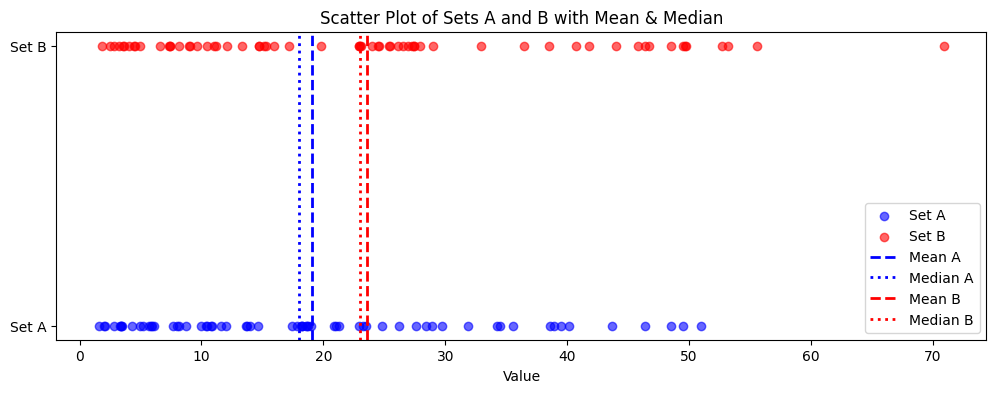

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Given arrays
A = np.array([ 5.9045706,  7.634388 , 24.80164  , 18.245747 ,  2.8070347,
        3.3002782, 23.467377 , 31.825815 , 18.974667 ,  1.5706726,
       38.616386 , 10.431969 , 13.650384 ,  5.8505945, 21.022682 ,
        4.291625 ,  7.9928827,  3.4233747, 21.279171 , 13.950924 ,
       11.598614 ,  8.175825 , 17.84459  ,  3.4778223, 40.14654  ,
       28.8838   ,  1.9906209,  5.1982875,  3.3984647, 10.81691  ,
       17.396404 , 10.397106 , 43.66082  ,  9.975403 , 28.42833  ,
       10.829836 , 18.715511 ,  8.719169 , 18.233765 , 18.648396 ,
        4.9638395, 22.962034 , 23.262573 , 49.54621  , 13.70779  ,
       14.639874 ,  5.718582 , 29.746744 , 38.905243 , 39.519775 ,
       34.460377 , 35.59498  , 11.98659  ,  2.083511 ,  6.114112 ,
       20.872433 , 34.218838 , 46.348305 , 27.621769 , 50.96823  ,
       26.2374   , 48.493736 , 18.184683 , 18.574913 ], dtype=np.float32)

B = np.array([ 7.350773 ,  9.6621475, 27.436563 , 23.111954 ,  3.2089257,
        3.6074066, 26.12007  , 40.710716 , 26.511017 ,  1.8437271,
       49.54541  , 11.027551 , 15.163449 ,  6.6174803, 23.988617 ,
        4.55308  , 10.4242735,  4.0231857, 26.956947 , 15.256362 ,
       13.3284   , 11.203775 , 24.442009 ,  3.5655468, 55.56772  ,
       38.500496 ,  2.8576322,  7.4344397,  4.436061 , 14.690008 ,
       17.152481 ,  8.978809 , 52.70938  , 12.092985 , 36.440964 ,
       14.702705 , 28.971634 ,  9.059126 , 27.925095 , 22.94552  ,
        4.9289064, 25.45509  , 25.368538 , 53.21978  , 24.553173 ,
       19.833376 ,  7.4192295, 44.00348  , 41.829964 , 49.716568 ,
       46.727055 , 45.799473 , 15.977612 ,  2.4773185,  8.114645 ,
       22.995745 , 48.55221  , 49.641193 , 32.956707 , 70.93584  ,
       27.258781 , 46.37383  , 22.927334 , 27.455675 ], dtype=np.float32)

# Compute statistics
mean_A, median_A = np.mean(A), np.median(A)
mean_B, median_B = np.mean(B), np.median(B)

# Plot
plt.figure(figsize=(12,4))

# Scatter plots
plt.scatter(A, np.zeros_like(A)+1, color='blue', alpha=0.6, label='Set A')
plt.scatter(B, np.zeros_like(B)+2, color='red', alpha=0.6, label='Set B')

# Mean and median markers
plt.axvline(mean_A, color='blue', linestyle='--', linewidth=2, label='Mean A')
plt.axvline(median_A, color='blue', linestyle=':', linewidth=2, label='Median A')

plt.axvline(mean_B, color='red', linestyle='--', linewidth=2, label='Mean B')
plt.axvline(median_B, color='red', linestyle=':', linewidth=2, label='Median B')

# Formatting
plt.yticks([1,2], ['Set A','Set B'])
plt.xlabel("Value")
plt.title("Scatter Plot of Sets A and B with Mean & Median")
plt.legend()
plt.show()


# What is the largest country? I think it is X. But I am not really sure

# old

In [ ]:
top_head_hypothesis_score = np.mean(hypothesis_scores)
top_head_doubt_score = np.mean(doubt_scores)
top_other_score = np.mean(other_scores)
top_head_hypothesis_score, top_head_doubt_score, top_other_score

In [ ]:
random_head_hypothesis_score = np.mean(hypothesis_scores)
random_head_doubt_score = np.mean(doubt_scores)
random_other_score = np.mean(other_scores)
random_head_hypothesis_score, random_head_doubt_score, random_other_score

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Input Data ---

top_heads_scores = {
    'User Hypothesis': 2.6334276,
    'User Doubt':0.33000344,
    'Other Prompt Sections': 8.967411254827311
}


# Group 2: Random 64 Heads
random_heads_scores = {
    'User Hypothesis': 1.1552463,
    'User Doubt': 0.19743735,
    'Other Prompt Sections': 10.469962649672667
}

# --- Data Preparation for Plotting ---
group_labels = ['Top related Heads', 'Least related Heads']
category_labels = list(top_heads_scores.keys()) # Ensure consistent order

# Calculate total scores for each group (across these categories)
total_top = sum(top_heads_scores.values())
total_random = sum(random_heads_scores.values())

# Calculate percentages for each category within each group
top_percentages = np.array([top_heads_scores[cat] / total_top * 100 for cat in category_labels])
random_percentages = np.array([random_heads_scores[cat] / total_random * 100 for cat in category_labels])

# Data for plotting (rows are categories, columns are groups)
data_percentages = np.array([
    [top_percentages[0], random_percentages[0]],  # Hypothesis
    [top_percentages[1], random_percentages[1]],  # Doubt
    [top_percentages[2], random_percentages[2]]   # Other
])

# --- Plotting ---
fig, ax = plt.subplots(figsize=(9, 5.5))

bar_width = 0.5

# --- MODIFICATION: Shift bars to the right ---
# Define a gap between the y-axis and the left edge of the first bar
gap_from_yaxis = 0.3  # Adjust this value as needed for desired spacing
# Calculate the center of the first bar
first_bar_center_x = gap_from_yaxis + bar_width / 2
# Create new x_positions, shifted by first_bar_center_x
# The original x_positions started at 0 (e.g., [0, 1])
# The new ones will start at first_bar_center_x (e.g., [0.35, 1.35] if gap=0.1, width=0.5)
x_positions = np.arange(len(group_labels)) + first_bar_center_x
# --- END MODIFICATION ---

colors = ['#FFA07A', '#A2D2A2', '#ADD8E6'] # User Hypothesis (Salmon), User Doubt (Pastel Green), Other (Light Blue)

# Plot stacked bars
bottom_values = np.zeros(len(group_labels))

for i, category in enumerate(category_labels):
    bars = ax.bar(
        x_positions, # Use new, shifted x_positions
        data_percentages[i],
        bar_width,
        bottom=bottom_values,
        label=category,
        color=colors[i],
        edgecolor='white'
    )
    for bar_idx, bar in enumerate(bars):
        height = bar.get_height()
        if height > 2:
            ax.text(
                bar.get_x() + bar.get_width() / 2.,
                bottom_values[bar_idx] + height / 2.,
                f'{height:.1f}%',
                ha='center',
                va='center',
                color='black', # Changed from 'white' to 'black' for better readability on light bars
                fontsize=9,
                # fontweight='bold'
            )
    bottom_values += data_percentages[i]


# --- Aesthetics and Labels ---
ax.set_ylabel('Aggregated Attention (%)', fontsize=11)
ax.set_title('Attention to Prompt Segments', fontsize=14, pad=15)
ax.set_xticks(x_positions) # Use new, shifted x_positions for ticks
ax.set_xticklabels(group_labels, rotation=0, ha='center', fontsize=10)
ax.set_ylim(0, 100)

# --- MODIFICATION: Adjust x-axis limits ---
# Set left x-limit to 0 so the y-axis is the leftmost boundary
xlim_left = 0
# Add some padding to the right of the last bar
padding_right_of_bars = gap_from_yaxis + 0.1 # Make it symmetrical or slightly larger than left gap
xlim_right = x_positions[-1] + bar_width / 2 + padding_right_of_bars
ax.set_xlim(xlim_left, xlim_right)
# --- END MODIFICATION ---

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)

legend = ax.legend(title="Prompt Segment", loc='upper left', bbox_to_anchor=(1.02, 1), frameon=False, fontsize=10)
plt.setp(legend.get_title(),fontsize='11')

plt.tight_layout(rect=[0, 0, 0.82, 1])
ax.grid(axis='y', linestyle=':', alpha=0.6, linewidth=0.5)

plt.savefig('attention_comparison_spaced.pdf', bbox_inches='tight')
plt.show()

print("Normalized Data for Verification:")
print(f"Top Heads Percentages: {dict(zip(category_labels, top_percentages))}")
print(f"Random Heads Percentages: {dict(zip(category_labels, random_percentages))}")